### Imports

In [1]:
import numpy as np
import pandas as pd

import gym
import gym_anytrading
import quantstats as qs

import matplotlib.pyplot as plt

from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
import datetime as dt

In [2]:
tickers = ['NESZ', 'CIMB', 'MAY', 'KLK']

df = {'prices':{},'directions':{}}
for ticker in tickers:
    df['prices'][ticker] = pd.read_csv('../day_data/{} MK Equity.csv'.format(ticker),parse_dates=True, index_col='Dates')
    df['directions'][ticker] = pd.read_csv('../directions/Directions {}.csv'
                                           .format(ticker),parse_dates=True, index_col='Dates').drop(columns='AVG').replace(-1,0)

    
val_start = df['prices'][tickers[0]].index.get_loc(dt.datetime(2018, 1, 1))
val_end = df['prices'][tickers[0]].index.get_loc(dt.datetime(2020, 1, 1))

print(val_start, val_end)

window_size = 1
start_index = window_size


env_maker_train = lambda: gym.make(
    'new_multi_env-v0',
    df = df, 
    frame_bound = (start_index, val_start),
    bankroll=100000.
)

env_train = DummyVecEnv([env_maker_train])

env_maker_val = lambda: gym.make(
    'new_multi_env-v0',
    df = df,
    frame_bound = (val_start + window_size, val_end),
    bankroll=100000.
)

env_val = DummyVecEnv([env_maker_val])

4695 5217
Continuous action space
Prices not visible
Standard reward
prices shape: (4695, 4) directions shape: (4695, 5)
Continuous action space
Prices not visible
Standard reward
prices shape: (522, 4) directions shape: (522, 5)


In [5]:
#policy_kwargs = dict(net_arch=[64, 'lstm', dict(vf=[128, 128, 128], pi=[64, 64])])

model = A2C('MlpPolicy', env_train, verbose=1) # , policy_kwargs=policy_kwargs)
#model = PPO("MlpPolicy", env_train, verbose=1)
#model = TD3("MlpPolicy", env_train, verbose=1)

model.learn(total_timesteps=100000)

Using cpu device
------------------------------------
| time/                 |          |
|    fps                | 2112     |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -7.07    |
|    explained_variance | -0.00145 |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | 1.58e+04 |
|    std                | 0.995    |
|    value_loss         | 4.57e+06 |
------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 2132      |
|    iterations         | 200       |
|    time_elapsed       | 0         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -7.08     |
|    explained_variance | -0.00164  |
|    learning_rate      | 0.0007    |
|    n_updates          | 199       |
|    polic

### Val Env (20 trials)

In [6]:
sharpes = []
cagrs = []

for i in range(20):
    env = env_maker_val()
    observation = env.reset()
    print(observation)

    c = 0
    while True:
        c+=1

        # action = env.action_space.sample()
        action, _states = model.predict(observation)

        #print(action)
        observation, reward, done, info = env.step(action)

        #env.render()
        if done:
            print("info:", info)
            print("iterations", c)
            break


    qs.extend_pandas()

    net_worth = pd.Series(np.array(env.history['net_worth']), index=df['prices']['NESZ'].index[val_start+2:val_end] )
    returns = net_worth.pct_change().iloc[1:]
    sharpes.append(qs.stats.sharpe(returns))
    cagrs.append(qs.stats.cagr(returns))
    print('QS:', qs.stats.sharpe(returns), qs.stats.cagr(returns))
    print("=====================================")
print(sharpes)
print(cagrs)
print(sum(sharpes)/len(sharpes))
print(sum(cagrs)/len(cagrs))

NESZ
CIMB
MAY
KLK
Continuous action space
prices shape: (522, 4) directions shape: (522, 5)
[[1.e+05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 3.e-01 1.e+00 3.e-01 1.e+00]]
info: {'total_reward': 27672.33999999996, 'total_profit': 27672.33999999996, 'position': array([64168.34,   432.  ,     0.  ,     0.  ,     0.  ]), 'delta': array([0., 0., 0., 0., 0.]), 'net_worth': 127672.34000000008}
iterations 520
QS: 1.2895934546525898 0.12800168337754791
NESZ
CIMB
MAY
KLK
Continuous action space
prices shape: (522, 4) directions shape: (522, 5)
[[1.e+05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 3.e-01 1.e+00 3.e-01 1.e+00]]
info: {'total_reward': 18411.64000000006, 'total_profit': 18411.64000000006, 'position': array([27859.64,   616.  ,     0.  ,     0.  ,     0.  ]), 'delta': array([27713.34,   232.  ,     0.  , -4997.  ,  -737.  ]), 'net_worth': 118411.63999999997}
iterations 520
QS: 0.9191436613658106 0.08625248317659007
NESZ
CIMB
MAY
KLK
Continuous action space
prices shape: (522, 4) directions sh

In [12]:
model = A2C.load('a2c_multi_best')
env = env_maker_val()
observation = env.reset()
print(observation)

c = 0
while True:
    c+=1

    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    #print(action)
    observation, reward, done, info = env.step(action)

    #env.render()
    if done:
        print("info:", info)
        print("iterations", c)
        break


qs.extend_pandas()

net_worth = pd.Series(np.array(env.history['net_worth']), index=df['prices']['NESZ'].index[val_start+2:val_end] )
returns = net_worth.pct_change().iloc[1:]
print('QS:', qs.stats.sharpe(returns), qs.stats.cagr(returns))

NESZ
CIMB
MAY
KLK
Continuous action space
prices shape: (522, 4) directions shape: (522, 5)
[[1.e+05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 3.e-01 1.e+00 3.e-01 1.e+00]]
info: {'total_reward': 29842.880000000026, 'total_profit': 29842.880000000026, 'position': array([65309.88,   439.  ,     0.  ,     0.  ,     0.  ]), 'delta': array([148.1,  -1. ,   0. ,   0. ,   0. ]), 'net_worth': 129842.87999999998}
iterations 520
QS: 1.1988140734376889 0.1375797211778751


### Plot Results

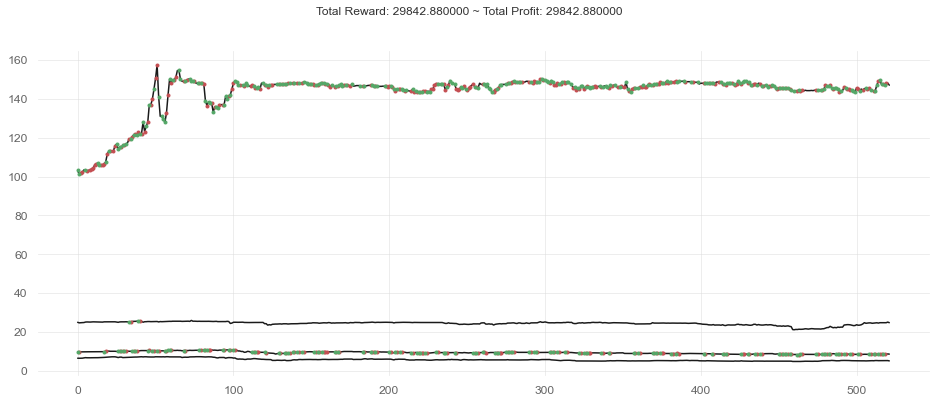

In [13]:
plt.figure(figsize=(16, 6))
env.render_all()
plt.show()

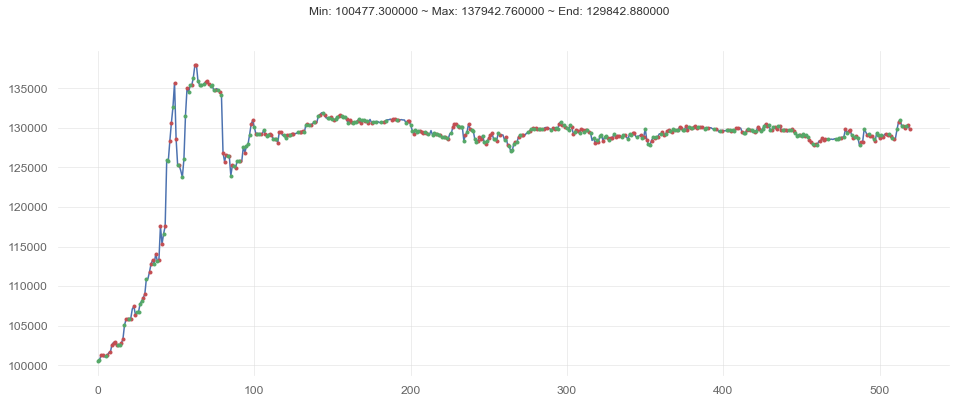

In [15]:
plt.figure(figsize=(16, 6))
env.render_net_worth()
plt.show()

In [16]:
print(np.array(env.history['position'])[:,0].mean())
print(np.array(env.history['net_worth']).mean())
print(np.array(env.history['position']).mean(axis=0))
#np.array(env.history['position'])[:,0].min()

53066.771769230734
127774.6125961538
[5.30667718e+04 4.79121154e+02 0.00000000e+00 6.53225000e+02
 8.48846154e+00]


### Analysis Using `quantstats`

                           Strategy
-------------------------  ----------
Start Period               2018-01-04
End Period                 2019-12-31
Risk-Free Rate             0.0%
Time in Market             85.0%

Cumulative Return          29.23%
CAGR﹪                     13.76%

Sharpe                     1.2
Smart Sharpe               1.06
Sortino                    1.93
Smart Sortino              1.72
Sortino/√2                 1.37
Smart Sortino/√2           1.21
Omega                      1.41

Max Drawdown               -10.13%
Longest DD Days            637
Volatility (ann.)          10.88%
Calmar                     1.36
Skew                       1.24
Kurtosis                   40.73

Expected Daily %           0.05%
Expected Monthly %         1.07%
Expected Yearly %          13.68%
Kelly Criterion            15.58%
Risk of Ruin               0.0%
Daily Value-at-Risk        -1.08%
Expected Shortfall (cVaR)  -1.08%

Gain/Pain Ratio            0.41
Gain/Pain (1M)             

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2018-04-03,2018-05-02,2019-12-31,637,-10.128042,-8.818223
2,2018-03-14,2018-03-20,2018-03-29,15,-8.786584,-8.185191
3,2018-03-01,2018-03-01,2018-03-06,5,-1.947419,-0.833053
4,2018-02-06,2018-02-06,2018-02-09,3,-0.984750,-0.681786
5,2018-02-26,2018-02-26,2018-02-28,2,-0.812517,-0.733054


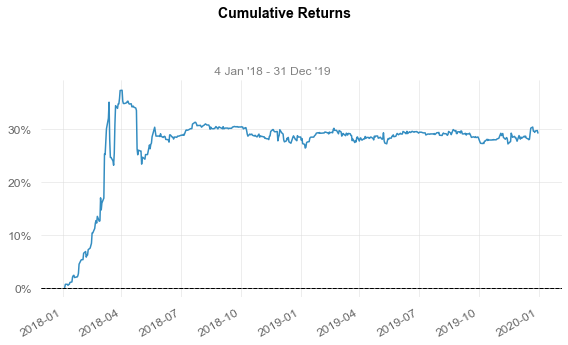

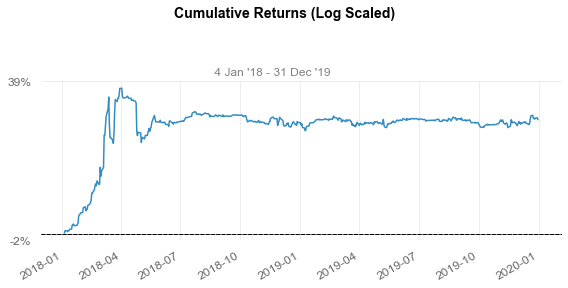

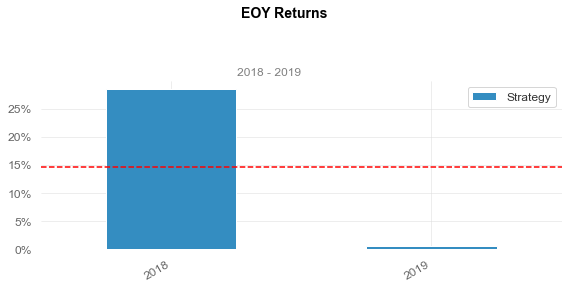

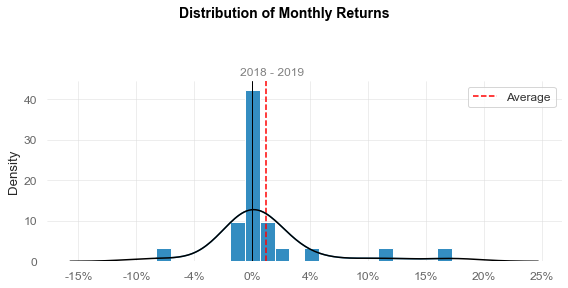

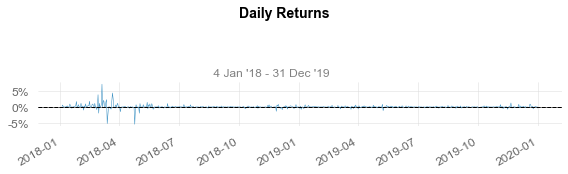

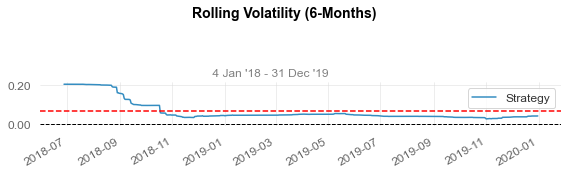

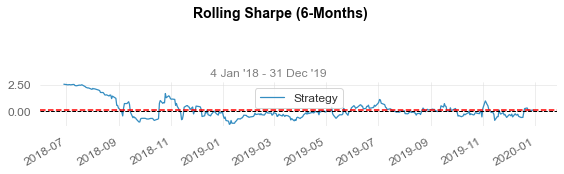

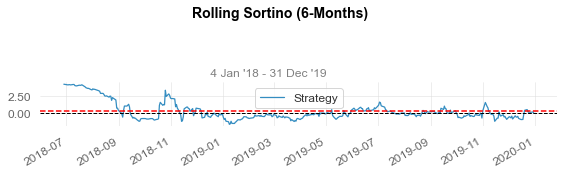

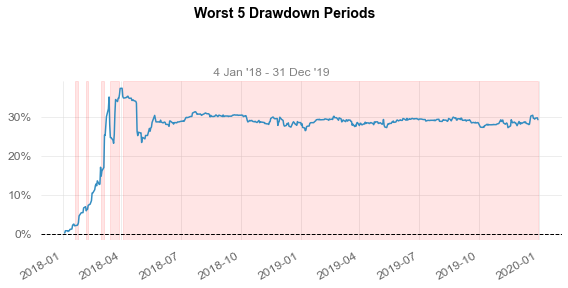

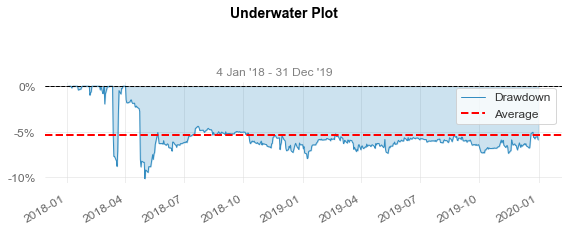

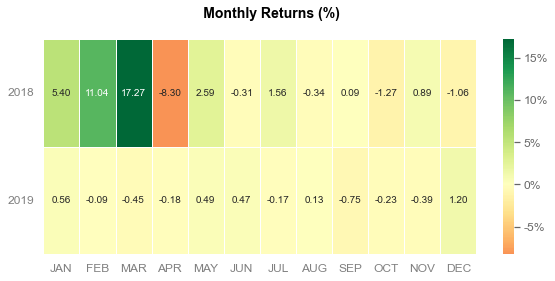

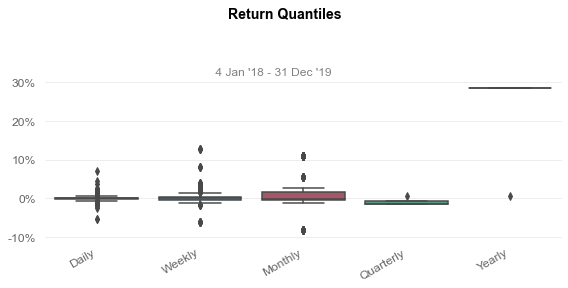

In [17]:
qs.extend_pandas()

net_worth = pd.Series(np.array(env.history['net_worth']), index=df['prices']['NESZ'].index[val_start+2:val_end] )#df['CIMB'].index[start_index+1:end_index])
returns = net_worth.pct_change().iloc[1:]

qs.reports.full(returns)
qs.reports.html(returns, output=True, download_filename='a2c_val_qs.html')

## Price Visible

In [3]:
tickers = ['NESZ', 'CIMB', 'MAY', 'KLK']

df = {'prices':{},'directions':{}}
for ticker in tickers:
    df['prices'][ticker] = pd.read_csv('../day_data/{} MK Equity.csv'.format(ticker),parse_dates=True, index_col='Dates')
    df['directions'][ticker] = pd.read_csv('../directions/Directions {}.csv'
                                           .format(ticker),parse_dates=True, index_col='Dates').drop(columns='AVG').replace(-1,0)

    
val_start = df['prices'][tickers[0]].index.get_loc(dt.datetime(2018, 1, 1))
val_end = df['prices'][tickers[0]].index.get_loc(dt.datetime(2020, 1, 1))

print(val_start, val_end)

window_size = 1
start_index = window_size


env_maker_train = lambda: gym.make(
    'new_multi_env-v0',
    df = df, 
    frame_bound = (start_index, val_start),
    bankroll=100000.,
    price_visible = True
)

env_train = DummyVecEnv([env_maker_train])

env_maker_val = lambda: gym.make(
    'new_multi_env-v0',
    df = df,
    frame_bound = (val_start + window_size, val_end),
    bankroll=100000.,
    price_visible = True
)

env_val = DummyVecEnv([env_maker_val])

4695 5217
Continuous action space
Prices visible
Standard reward
prices shape: (4695, 4) directions shape: (4695, 5)
Continuous action space
Prices visible
Standard reward
prices shape: (522, 4) directions shape: (522, 5)


In [3]:
model = A2C('MlpPolicy', env_train, verbose=1)
model.learn(total_timesteps=1000)

Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 2028      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -7.11     |
|    explained_variance | -0.000333 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | 2.76e+03  |
|    std                | 1         |
|    value_loss         | 2.89e+05  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 2152      |
|    iterations         | 200       |
|    time_elapsed       | 0         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -7.08     |
|    explained_variance | -0.0023   |
|    learning_rate      | 0.0007    |
|    n_updates          | 199    

In [4]:
env = env_maker_val()
observation = env.reset()
print(observation)

c = 0
while True:
    c+=1

    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    #print(action)
    observation, reward, done, info = env.step(action)

    #env.render()
    if done:
        print("info:", info)
        print("iterations", c)
        break


qs.extend_pandas()

net_worth = pd.Series(np.array(env.history['net_worth']), index=df['prices']['NESZ'].index[val_start+2:val_end] )
returns = net_worth.pct_change().iloc[1:]
print('QS:', qs.stats.sharpe(returns), qs.stats.cagr(returns))

Continuous action space
prices shape: (522, 4) directions shape: (522, 5)
[[1.000e+05 0.000e+00 0.000e+00 0.000e+00 0.000e+00]
 [0.000e+00 3.000e-01 1.000e+00 3.000e-01 1.000e+00]
 [0.000e+00 1.032e+02 6.540e+00 9.800e+00 2.500e+01]]
info: {'total_reward': 9716.660000000169, 'total_profit': 9716.660000000169, 'position': array([  31.54,    0.  ,    0.  , 1558.  , 3880.  ]), 'delta': array([  -74.82,  -228.  , -6380.  , -2369.  ,  3521.  ]), 'net_worth': 109716.66000000024}
iterations 520
QS: 0.43399763233418054 0.044327393965561734


## Reshaped Reward

In [4]:
tickers = ['NESZ', 'CIMB', 'MAY', 'KLK']

df = {'prices':{},'directions':{}}
for ticker in tickers:
    df['prices'][ticker] = pd.read_csv('../day_data/{} MK Equity.csv'.format(ticker),parse_dates=True, index_col='Dates')
    df['directions'][ticker] = pd.read_csv('../directions/Directions {}.csv'
                                           .format(ticker),parse_dates=True, index_col='Dates').drop(columns='AVG').replace(-1,0)

    
val_start = df['prices'][tickers[0]].index.get_loc(dt.datetime(2018, 1, 1))
val_end = df['prices'][tickers[0]].index.get_loc(dt.datetime(2020, 1, 1))

print(val_start, val_end)

window_size = 1
start_index = window_size


env_maker_train = lambda: gym.make(
    'new_multi_env-v0',
    df = df, 
    frame_bound = (start_index, val_start),
    bankroll=100000.,
    new_reward = True
)

env_train = DummyVecEnv([env_maker_train])

env_maker_val = lambda: gym.make(
    'new_multi_env-v0',
    df = df,
    frame_bound = (val_start + window_size, val_end),
    bankroll=100000.,
    new_reward = True
)

env_val = DummyVecEnv([env_maker_val])

4695 5217
Continuous action space
Prices not visible
New reward
prices shape: (4695, 4) directions shape: (4695, 5)
Continuous action space
Prices not visible
New reward
prices shape: (522, 4) directions shape: (522, 5)


In [6]:
model = A2C('MlpPolicy', env_train, verbose=1)
model.learn(total_timesteps=1000)

Using cpu device
-------------------------------------
| time/                 |           |
|    fps                | 2004      |
|    iterations         | 100       |
|    time_elapsed       | 0         |
|    total_timesteps    | 500       |
| train/                |           |
|    entropy_loss       | -7.14     |
|    explained_variance | -6.32e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 99        |
|    policy_loss        | -1.6e+06  |
|    std                | 1.01      |
|    value_loss         | 8.73e+10  |
-------------------------------------
-------------------------------------
| time/                 |           |
|    fps                | 2049      |
|    iterations         | 200       |
|    time_elapsed       | 0         |
|    total_timesteps    | 1000      |
| train/                |           |
|    entropy_loss       | -7.17     |
|    explained_variance | -6.32e-06 |
|    learning_rate      | 0.0007    |
|    n_updates          | 199    

In [7]:
env = env_maker_val()
observation = env.reset()
print(observation)

c = 0
while True:
    c+=1

    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    #print(action)
    observation, reward, done, info = env.step(action)

    #env.render()
    if done:
        print("info:", info)
        print("iterations", c)
        break


qs.extend_pandas()

net_worth = pd.Series(np.array(env.history['net_worth']), index=df['prices']['NESZ'].index[val_start+2:val_end] )
returns = net_worth.pct_change().iloc[1:]
print('QS:', qs.stats.sharpe(returns), qs.stats.cagr(returns))

Continuous action space
prices shape: (522, 4) directions shape: (522, 5)
[[1.e+05 0.e+00 0.e+00 0.e+00 0.e+00]
 [0.e+00 3.e-01 1.e+00 3.e-01 1.e+00]]
info: {'total_reward': -113106986.11080018, 'total_profit': -18043.81000000002, 'position': array([36770.59,     0.  ,     0.  ,     0.  ,  1822.  ]), 'delta': array([-45732.2,      0. ,      0. ,      0. ,   1822. ]), 'net_worth': 81956.19}
iterations 520
QS: -1.017758131839321 -0.09572857086348019


## Discrete (not implemented)

In [9]:
tickers = ['NESZ', 'CIMB', 'MAY', 'KLK']

df = {'prices':{},'directions':{}}
for ticker in tickers:
    df['prices'][ticker] = pd.read_csv('../day_data/{} MK Equity.csv'.format(ticker),parse_dates=True, index_col='Dates')
    df['directions'][ticker] = pd.read_csv('../directions/Directions {}.csv'
                                           .format(ticker),parse_dates=True, index_col='Dates').drop(columns='AVG').replace(-1,0)

    
val_start = df['prices'][tickers[0]].index.get_loc(dt.datetime(2018, 1, 1))
val_end = df['prices'][tickers[0]].index.get_loc(dt.datetime(2020, 1, 1))

print(val_start, val_end)

window_size = 1
start_index = window_size


env_maker_train = lambda: gym.make(
    'new_multi_env-v0',
    df = df, 
    frame_bound = (start_index, val_start),
    bankroll=100000.,
    discrete = True
)

env_train = DummyVecEnv([env_maker_train])

env_maker_val = lambda: gym.make(
    'new_multi_env-v0',
    df = df,
    frame_bound = (val_start + window_size, val_end),
    bankroll=100000.,
    discrete = True
)

env_val = DummyVecEnv([env_maker_val])

4695 5217
Discrete action space
prices shape: (4695, 4) directions shape: (4695, 5)
Discrete action space
prices shape: (522, 4) directions shape: (522, 5)


In [10]:
model = DQN('MlpPolicy', env_train, verbose=1)
model.learn(total_timesteps=1000)

NameError: name 'DQN' is not defined

In [ ]:
env = env_maker_val()
observation = env.reset()
print(observation)

c = 0
while True:
    c+=1

    # action = env.action_space.sample()
    action, _states = model.predict(observation)

    #print(action)
    observation, reward, done, info = env.step(action)

    #env.render()
    if done:
        print("info:", info)
        print("iterations", c)
        break


qs.extend_pandas()

net_worth = pd.Series(np.array(env.history['net_worth']), index=df['prices']['NESZ'].index[val_start+2:val_end] )
returns = net_worth.pct_change().iloc[1:]
print('QS:', qs.stats.sharpe(returns), qs.stats.cagr(returns))